# Variational Inference
Variational inference is a method which is used to approximate distributions over latent variables, given a set of data points. It has also been used in Bayesian deep learning and forms a starting point for the VAE. 

## Introduction

### The problem

As always we have some datapoints and we'd like to do something with them. We'll come to specific examples in a moment. For now, say we have $n$ datapoints that we denote as $\mathbf{x} = \{\mathbf{x}_1 \ldots \mathbf{x}_n$\}. We also have, associated with these, latent variables $\mathbf{z}_1 \ldots \mathbf{z}_n$. 

$\mathbf{x}_i$ are distributed as $p(\mathbf{x}_i|\mathbf{z}_i, \theta)$. $\mathbf{z}_i$ in turn are distributed according to $p(\mathbf{z}_i| \theta)$. So for generating each datapoint, firstly a  value of $\mathbf{z}_i$ is selected from $p(\mathbf{z}_i| \theta)$. We can only observe the data points $\mathbf{x}$ but we would like to find the posterior distribution over $\mathbf{z}$ i.e. $p(\mathbf{z}|\mathbf{x}, \theta)$. We can also have a more general version of this problem where $\theta$ is not given so we actually want to find $p(\mathbf{z}, \theta|\mathbf{x})$.

### Mixture of Gaussians

Let us see an example of this data-generating process in action. You may be familiar with Gaussian mixture models. Briefly, the datapoint $\mathbf{x}^{(i)} $ is considered to belong to any of $K$ different Gaussians where the latent variable $z^{(i)} \in \{1 \ldots K\}$ indicates the Gaussian from which $\mathbf{x}^{(i)} $ is drawn. Therefore $p(z^{(i)} ; \theta)$ is a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution), with probabilities $\pi_1 \ldots \pi_K$ where:

$$p(z^{(i)}  = k; \theta) = \pi_k$$  
$$\sum_k{\pi_k}=1$$

And for $\mathbf{x}^{(i)} $ we have:

$$p(\mathbf{x}^{(i)} |z^{(i)}  = k;\theta) = \mathcal{N}(\mathbf{x}^{(i)} ; \mathbf{\mu}_k, \Sigma_k)$$

The parameters $\theta$ consist of $\pi_k$, $\mathbf{\mu}_k$ and $\Sigma_k$.

To get a feel for the data-generating process let's now generate some data for 1-D Gaussians with $k=3$. Note that the categorical distribution is a special case of the [multinomial distribution](https://en.wikipedia.org/wiki/Multinomial_distribution) when $n=1$ and `np.random.multinomial` returns a one-hot vector of length $k$ for each sample so we take the argmax to get scalar values for $z^{(i)} \in \{0, 1, \ldots, k-1\}$. 

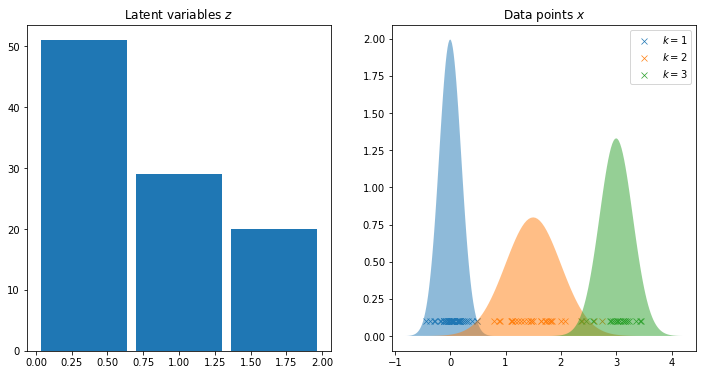

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import pickle
import os
from scipy.stats import norm
from sklearn.metrics import confusion_matrix
%matplotlib inline

np.random.seed(1)
plt.figure(figsize=(12,6))


#PARAMETERS
pi = [0.5,0.3,0.2] #Prior probabilities for z
mu = np.array([0,1.5,3])
std = np.array([0.2, 0.5, 0.3])

#GENERATE LATENT VARIABLES

#The categorical distribution is a special case of the multinomial distribution when n = 1.
#np.random.multinomial returns a one-hot vector for each sample hence the argmax.
def categorical(pvals, size):
    onehot = np.random.multinomial(n=1, pvals=pvals, size=size)
    return np.argmax(onehot, axis=1)

z = categorical(pvals=pi, size=100) #Samples for z 
plt.subplot(1,2,1)
plt.hist(z, bins=3, rwidth=0.9)
plt.title('Latent variables $z$')

#GENERATE DATAPOINTS
x = np.random.normal(loc=mu[z], scale=std[z])

plt.subplot(1,2,2)
for i, (m, s) in enumerate(zip(mu, std)):
    diff = 4*s
    a = np.arange(m-diff, m+diff, 2*diff/100)
    poly = plt.fill(a, norm.pdf(a, loc=m, scale=s), alpha=0.5)[0]
    x_in_gaussian = x[z==i]
    plt.scatter(x_in_gaussian, 0.1*np.ones_like(x_in_gaussian), 
                color=poly.get_facecolor(),  linewidth=0.7, marker='x', alpha=1, label='$k={}$'.format(i+1))
    
plt.title('Data points $x$')
plt.legend();

Of course in practice we only have access to the points $\mathbf{x}$ and need to infer values or a distribution over $z$, $\mu_k$, $\sigma_k^2$ and $\pi_k$. Notice that here we want to find $p(\mathbf{z}, \theta|\mathbf{x})$ rather than $p(\mathbf{z}|\mathbf{x}, \theta)$. If we knew these values, then we could cluster each datapoint by assigning it to the Gaussian under which its probability is the highest. This could be done in an unsupervised setting when our datapoints are unlabelled as well as with labelled data, by trying to fit a mixture of K Gaussians corresponding to K classes. For example the plot below shows datapoints from the famous iris dataset, using only two out the four attributes.

What is more, once we fit a distribution to the data, we can generate new examples. It might not seem particularly interesting to generate examples of the toy data we have been considering but this forms the basis of image generation methods such as Variational Autoencoders.

In many cases, including mixtures of Gaussians, it turns out that we can't analytically solve for a distribution over $\mathbf{z}$ but need to resort to other methods, such as variational inference.

### Image denoising 

Let's look at another example where we would like to find a distribution over latent variables corresponding to a set of datapoints. We have a grayscale image which we have binarised so that the pixel values lie between 0 and 1 for simplicity in calculations. We have added noise to the image by sampling a value from a normal distribution centred at the original pixel value. Note that after adding noise, the pixels become continuous valued so before plotting we discretize the image again so that its values are in $\{-1, 1\}$.

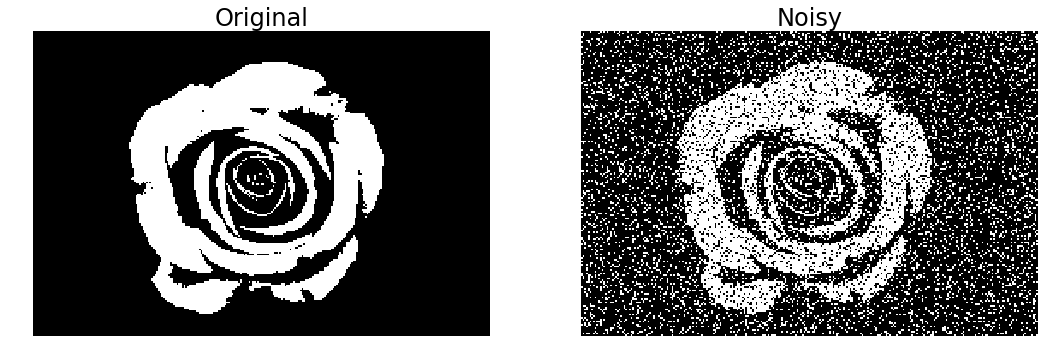

In [6]:
plt.figure(figsize=(18,9))
img = plt.imread('rose.jpeg')[...,0][::16, ::16]
num_pixels = img.size
m = np.mean(img)
img_minus_plus = 1*(img > 128) - 1*(img <= 128) #Make the values either -1 or 1
sigma = 1
img_noised =  np.random.normal(loc = img_minus_plus, scale=sigma)

for i, (im, title) in enumerate(zip([img_minus_plus, img_noised], ['Original', 'Noisy'])):
    plt.subplot(1,2,i+1)
    plt.imshow(im>0, 'gray')
    plt.title(title, fontsize=24)
    plt.axis('off');


Here the datapoints are the pixel values of the noisy image $\mathbf{x}^{(i)}$. The latent variables $\mathbf{z}^{(i)}$ are the original values of these points. Let us consider an image of size $H \times W = D$. First we define a set $N_i$ for each pixel which contains the indicies of all the neighbouring pixels. We then propose the following model:

$$p(\mathbf{x}, \mathbf{z}) = p(\mathbf{x}\vert\mathbf{z})p(\mathbf{z})$$

$$p(\mathbf{z}) \propto \exp\left(\frac{1}{2}\sum_{i=1}^D\sum_{j\in \mathcal{N}_i}W_{ij}z_iz_j\right),\text{ }W_{ij} = W_{ji}$$

$$p(\mathbf{x}\vert\mathbf{z}) = \prod_i p(\mathbf{x}_i\vert\mathbf{z}_i)$$

Each noisy pixel depends on the original pixel value in some way. For example above we use a normal distribution centred on $z_i$. It will be convenient to write this as the exponential of the log of the distribution, where we write it only as a function of $z_i$ since $x_i$ are known:

$$p(\mathbf{x}\vert\mathbf{z}) = \exp\left(\sum_i L_i(z_i)\right)$$

To calculate the posterior $p(\mathbf{z}\vert\mathbf{x}) = \frac{p(\mathbf{x}, \mathbf{z})}{p(\mathbf{x})}$ we need to calculate $p(\mathbf{x}) = \sum_{\mathbf{z}} p(\mathbf{x}\vert\mathbf{z})p(\mathbf{z})$, which requires summing over all the $2^D$ possible values of $\mathbf{z}$, which is intractable for arbitrary image sizes.


## Understanding variational inference

### The problem again

Let us now state our problem in general terms. As mentioned earlier we want to find the posterior distribution over the latent variables $\mathbf{z}$ $p(\mathbf{z}|\mathbf{x}, \theta)$, or the joint the posterior distribution over the $\mathbf{z}$ as well as the paramaters $\theta$ $p(\mathbf{z}, \theta|\mathbf{x})$. For simplicity we will consider $p(\mathbf{z}|\mathbf{x},\theta)$ for the moment. Using Bayes rule we can write this as:

$$p(\mathbf{z}|\mathbf{x}, \theta) = \frac{p(\mathbf{x}|\mathbf{z}, \theta)p(\mathbf{z}|\theta)}{p(\mathbf{x}|\theta)}$$

As we saw in the examples, the problem with finding $p(\mathbf{z}|\mathbf{x})$ for arbitrary distributions $p(\mathbf{x}|\mathbf{z})$ and $p(\mathbf{z})$ is that it may not be possible to calculate the denominator $p(\mathbf{x})$ analytically. 

### How variational inference approaches the problem 

Variational inference instead picks an alternative distribution $q(\mathbf{z})$ and optimises its parameters, which we denote by $\phi$, until this distribution is close to $p(\mathbf{z}|\mathbf{x}; \theta).$ The closeness is measured by the KL-divergence between $q(\mathbf{z})$ and $p(\mathbf{z}|\mathbf{x}; \theta)$:

$$D_{KL}(q||p) = E_q\left[\log\left(\frac{q(\mathbf{z})}{p(\mathbf{z}|\mathbf{x}, \theta)}\right)\right] = E_q\left[\log(q(\mathbf{z})) - \log(p(\mathbf{z}|\mathbf{x}, \theta))\right]$$

The KL-divergence is always non-negative and equal to 0 only when $q = p$. Now note that $D_{KL}(p||q) \neq D_{KL}(q||p)$ for $q \neq p$ so using $D_{KL}(p||q)$ as the distance metric would lead to different results. 

But notice that even $D_{KL}(p||q)$ demands knowledge of the posterior $p(\mathbf{z}|\mathbf{x}, \theta)$. However it turns out that we can indirectly minimise $D_{KL}(q||p)$ without having to calculate it explicitly. We instead minimise $E_q\left[\log\left(\frac{q(\mathbf{z})}{p(\mathbf{x}, \mathbf{z}, \theta)}\right)\right]$, which looks similar to the KL divergence except that the denominator of the logterm contains $p(\mathbf{x},\mathbf{z}, \theta) = p(\mathbf{x}|\mathbf{z}, \theta)p(\mathbf{z}, \theta)$. This is the unnormalised posterior, which we assume that we can calculate.

Minimising this expectation with respect to $q$ minimises $D_{KL}(q||p)$ because:

$$E_q\left[\log\left(\frac{q(\mathbf{z})}{p(\mathbf{x}, \mathbf{z}| \theta)}\right)\right]
= E_q[\log(q(\mathbf{z}))] - E_q[\log(p(\mathbf{z}|\mathbf{x}, \theta)p(\mathbf{x}| \theta))]
\\= E_q[\log(q(\mathbf{z}))] - E_q[\log(p(\mathbf{z}|\mathbf{x}, \theta))] -  E_q[\log(p(\mathbf{x}| \theta))]
\\= E_q\left[\log\left(\frac{q(\mathbf{z})}{p(\mathbf{z}|\mathbf{x}, \theta)}\right)\right] -  E_q[\log(p(\mathbf{x}| \theta))]
\\= D_{KL}(q||p) - E_q[\log(p(\mathbf{x}| \theta))]$$ 


In other words this is $D_{KL}(q||p)$ plus a term that is constant with respect to $q$, which means

$$q^* = \arg\min_q E_q\left[{\log(q(\mathbf{z}))}/{p(\mathbf{x}, \mathbf{z}| \theta))}\right]
 = \arg\min_q D_{KL}(q||p)$$ 
    
so that finding $q$ which minimises the term pulls $q$ closer to $p(\mathbf{x}, \mathbf{z}| \theta)$ which is what we desire.

Since $0 \leq p(\mathbf{x}| \theta)) \leq 1$, $-\log(p(\mathbf{x}| \theta)) \geq 0$, which means that $D_{KL}(q||p)$ is the lower bound of the term we are trying to optimise 

$$E_q\left[\log\left(\frac{q(\mathbf{z})}{p(\mathbf{x}, \mathbf{z}| \theta)}\right)\right] \geq D_{KL}(q||p)$$

#### ELBO
Another way of arriving at this result is to maximise the evidence lower bound or ELBO. The ELBO is given by $E_q\left[\log(p(\mathbf{x}, \mathbf{z}| \theta)/q(\mathbf{z}))\right]$. From above we note that the ELBO equals $E_q[\log(p(\mathbf{x}| \theta))] - D_{KL}(q||p)$, which means that maximising the ELBO with respect to $q$ minimises the KL-divergence between $q$ and $p$:

$$q^* = \arg\max_q \text{ELBO}
 = \arg\min_q D_{KL}(q||p)$$ 

### Mean field method

We assume that the distributions for each latent variable $z_j$ is independent so that $q$ can be expressed as the product over distributions $q_j(z_j)$:

$$q(\mathbf{z}) = \prod_j q_j(z_j)$$


$$E_q\left[\log\left(\frac{q(\mathbf{z})}{p(\mathbf{x}, \mathbf{z}| \theta)}\right)\right]
=E_q\left[\log\left(\prod_j q_j(z_j)\right) - \log(p(\mathbf{x}, \mathbf{z}| \theta))\right]\\
=E_q\left[\sum_j\log(q_j(z_j))\right] - E_q\left[\log(p(\mathbf{x}, \mathbf{z}| \theta))\right]\\
=\sum_jE_q\left[\log(q_j(z_j))\right] - E_q\left[\log(p(\mathbf{x}, \mathbf{z}| \theta))\right]\\
=\sum_jE_{q_j}\left[\log(q_j(z_j))\right] - E_q\left[\log(p(\mathbf{x}, \mathbf{z}| \theta))\right]\\
$$

since $\log(q_j(z_j))$ depends only on $z_j$.

Now let us consider this as a function of $q_k$, $l(q_k)$:

$$l(q_k) =\sum_jE_{q_j}\left[\log(q_j(z_j))\right] - E_q\left[\log(p(\mathbf{x}, \mathbf{z}| \theta))\right]
\\=E_{q_k}\left[\log(q_k(z_k))\right] + \sum_{j\neq k}E_{q_j}\left[\log(q_j(z_j))\right] - E_{q_k}\left[E_{q_{-k}}\left[\log(p(\mathbf{x}, \mathbf{z}| \theta))\right]\right]
\\= E_{q_k}\left[\text{const.} + \log(q_k(z_k)) - E_{-q_k}\left[\log(p(\mathbf{x}, \mathbf{z}| \theta))\right]\right]$$

since $\sum_{j\neq k}E_{q_j}\left[\log(q_j(z_j))\right]$ is does not depend on $q_k$.

Solving for function which minimises $l(q_k)$, making it equal $0$:

$$\log(q_k(z_k)) = \text{const.} + E_{-q_k}\left[\log(p(\mathbf{x}, \mathbf{z})\right]
\implies q_k(z_k) \propto \exp\left(E_{-q_k}\left[\log(p(\mathbf{x}, \mathbf{z})\right]\right)$$



#### How it works 

1. Propose a form for $q_j$. This can be a specific distribution like a Normal distribution or it can just be some function with parameters.
2. Derive expressions for $q_j$ using the proposed functions.
3. Find expressions for the $\phi_j$, the parameters of $q_j$, given $\phi_{-j}$
4. Initialise $\phi_j$ for all $j$ and then iteratively update $\phi_j$ until convergence.

## Variational inference for image denoising

Recall that we would like to estimate a conditional distribution for the original image $\mathbf{z}$ given the noisy image $\mathbf{x}$. We want to find a $q(\mathbf{z})$ that approximates $p(\mathbf{z}\lvert \mathbf{x})$. The steps of variational inference using the mean field model are as follows:



1\. The components of the vector $\mathbf{z}$ are the pixel values of image matrix flattened to form a vector. For each pixel $z_j$ propose a distribution $q_j(z_j; \mu_j)$ where $\mu_j$ is the mean of $z_j$:

$$p(\mathbf{x}, \mathbf{z}) \propto \exp\left(\sum_i L_i(\mathbf{z}_i)\right)\exp\left(\frac{1}{2}\sum_{i=1}^D\sum_{j\in \mathcal{N}_i}W_{ij}z_iz_j\right)$$

2\. First let us isolate the terms on the log of the above that depend on $z_l$

$$\log p(\mathbf{x}, \mathbf{z}) = \sum_i L_i(\mathbf{z}_i) + \frac{1}{2}\sum_{i=1}^D\sum_{j\in \mathcal{N}_i}W_{ij}z_iz_j
= \text{const.}  + L_l(\mathbf{z}_l) + \frac{1}{2}\sum_{j \in N_l}W_{lj}z_lz_j + \frac{1}{2}\sum_{j \in N_l}W_{jl}z_jz_l$$

Taking the expectation involves simply replacing $z_j, j \neq l$ with their means $\mu_j$:

$$E_{-q_{l}}\left[\log p(\mathbf{x}, \mathbf{z}) \right] = \text{const.} + L_l(\mathbf{z}_l)
+ z_l\sum_{j \in N_l}W_{lj}z_j 
\\ \implies q_l(z_l) \propto \exp\left(L_l(\mathbf{z}_l)
+ z_l\sum_{j \in N_l}W_{lj}z_j\right)$$

Let $n_l = \sum_{j \in N_l}W_{lj}z_j$. Then

$$q_l(1) \propto \exp\left(L_l(1) + n_l\right)$$

$$q_l(-1) \propto \exp\left(L_l(-1) - n_l\right)$$

$$q_1(1) = \frac{\exp\left(L_l(1) + n_l\right)}{\exp\left(L_l(1) + n_l\right) + \exp\left(L_l(-1) - n_l\right)} = \frac{1}{1 + \exp\left(-(L_l(1) - L_l(-1) + 2n_l)\right)} = \sigma(2a_l)$$

$$q_1(-1) = \frac{\exp\left(L_l(-1) - n_l\right)}{\exp\left(L_l(1) + n_l\right) + \exp\left(L_l(-1) - n_l\right)} = \frac{1}{1 + \exp\left(L_l(-1) - L_l(1) - 2n_l)\right)} = \sigma(-2a_l)$$

$$a_l = L_l(1) - L_l(-1) + 2n_l$$

3\. Using these values the mean $\mu_l$ can be found:

$$\mu_l = E_{q_l}[z_l] = \sigma(2a_l) - \sigma(-2a_l) = \tanh(a_l)$$

The subsequent steps will be in code.

#### Code demo

In [7]:
#Define values
img = plt.imread('rose.jpeg')[...,0][::16, ::16]
num_pixels = img.size
img_minus_plus = 1*(img > 128) - 1*(img <=128) #Make the values either -1 or 1
sigma = 1
#Continuous valued noised image - values need to be continuous for the denoising step
img_noised =  np.random.normal(loc = img_minus_plus, scale=sigma)

#Here Wij = 1 for all ij hence we simply sum over the neighbours
def logprob_z_term(img):
     # shape: (4, 2)
    delta = np.array([[0,-1],[0,1],[-1,0],[1,0]])
     # shape: (h*w, 2)
    inds = np.indices(img.shape).reshape((2,-1)).T
    
    #Get all neighbours
    # shape: (h*w, 1, 2) + (4, 2) -> (h*w, 4, 2)
    neighbour_inds = inds[:,np.newaxis]+delta 
    
    #Determine which pairs of indices that within bounds
    # shape: (h*w, 4, 1)
    mask = np.all(np.logical_and(neighbour_inds >= 0, neighbour_inds < img.shape), axis=-1, keepdims=True)
    
    #Stack the indices in order retrieve the values, making those which are out of bounds equal [0,0] using mask
    # shape: (h*w*4, 2)
    inds_stacked = np.concatenate(neighbour_inds*mask, axis=0)
    
    #Retrieve and reshape
    # shape: (h*w, 4, 1)
    neighbours = img[inds_stacked[:,0], inds_stacked[:,1]].reshape(mask.shape)
    
    #Sum for each location after making values out of bounds 0 by multiplying with mask
    # shape: (h*w, 1)
    result = np.sum(neighbours*mask, axis=1)/2
    # shape: (h, w)
    return result.reshape(img.shape)

def logprob_x_given_z(z):
    return norm(loc=img_noised, scale=sigma).logpdf(z)

L_term = logprob_x_given_z(1) - logprob_x_given_z(-1)
    
#4. Initialise mu
mu0 = np.random.randint(-1,2,size=img.shape)
lm = 0.5
it = 0
errors = []
imgs = [img_noised]
tol = 1e-9

#5. Update
while True:
    it +=1
    n = logprob_z_term(mu0)
    a = L_term + 2*n

    #As suggested in [Murphy's Machine Learning, 2012, chapter 21, page 739, equation 21.52] 
    #we will using an exponential moving average rather than just assigning the new value
    mu = (1-lm)*mu0 + lm*np.tanh(a)
    errors.append(np.max((mu0-mu)**2))
    
    #Since difference between consecutive images becomes small very quickly,
    #save just the first 24 images for visualing denoising process, 
    #for which the differences are more obvious.
    if it<25:
        imgs.append(mu)
    sys.stdout.write('\rIter %i, error %2.9f'%(it,errors[-1]))
    
    if errors[-1] < tol:
        break
    mu0 = mu


Iter 289, error 0.000000001

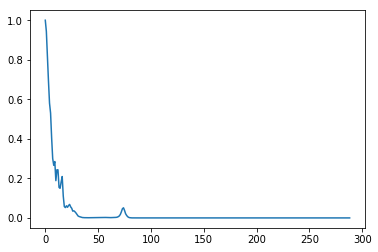

In [8]:
plt.plot(errors)

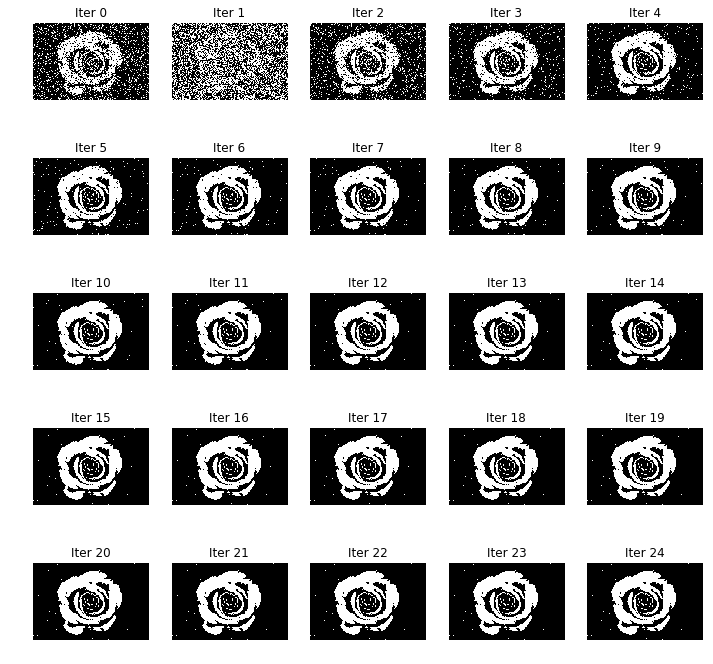

In [9]:
plt.figure(figsize=(12,12))
for i, im in enumerate(imgs):
    plt.subplot(5,5,i+1)
    plt.imshow(im>0, 'gray')
    plt.title('Iter %i'%(i))
    plt.axis('off');

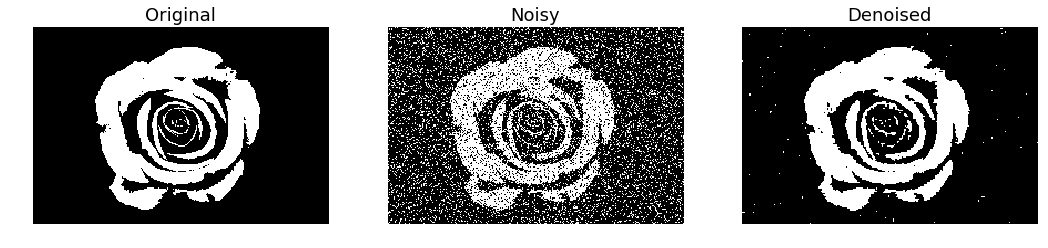

In [11]:
plt.figure(figsize=(18,6))
for i, (im, title) in enumerate(zip([img_minus_plus, img_noised>0, mu>0], ['Original', 'Noisy', 'Denoised'])):
    plt.subplot(1,3,i+1)
    plt.imshow(im, 'gray')
    plt.title(title, fontsize=18)
    plt.axis('off');


## Variational inference for mixture of Gaussians

For the Ising model we only estimated distributions for the latent variable $\mathbf{z}$, the original image. In this example we will estimate distributions for both the parameters of the Gaussians $\theta$ as well as the latent variables $z$. As this is a more involved example we will write code as well go along so that it comes together more easily at the end.


We will make some simplifications. First we will work with 1D Gaussians and assume that all the Gaussians have unit variance, i.e. $\sigma_k = 1$ for $k = 1 \ldots K$. So $\mu_k$ is the only parameter whose distribution we need to estimate. 

We assume a normal prior distribtuion for $\mu_k$, with zero mean and a known variance $\sigma$:

$$\mu_k \sim \mathcal{N}(0, \sigma^2)$$

A further simplification will be to assume that $z^{(i)}$ is equally likely to be any of ${1 \ldots K}$ so that

$$
p(z^{(i)} = k) = \frac{1}{K} 
$$


Based on these distributions let us draw some datapoints $x^{i}$

In [12]:
def sample_x(num_samples, num_gaussians, sigma, sigma_x=1):
    #Since each z has equal probability sample from a discrete uniform distribution,
    #here in the range [0, K-1] because we want to use z for indexing
    z = np.random.randint(0, num_gaussians, num_samples)
    #Draw K samples from a normal distribution for mu_1 ... mu_K
    mu = np.random.normal(loc=0, scale=sigma, size=num_gaussians)
    #Select from mu according to z and use this to draw samples
    #from normal distributions parameterised by mu
    
    #Sort mu in ascending order for ease of comparison with the VI results 
    mu = np.sort(mu)
    x = np.random.normal(loc=mu[z], scale=sigma_x)
    return z, mu, x

In [13]:
num_samples = 1000
num_gaussians = 3
sigma = 10
sigma_x = 1
z, mu, x = sample_x(num_samples, num_gaussians, sigma, sigma_x)

In [14]:
print(mu)

[-17.0289241   -5.83745189   9.1717052 ]


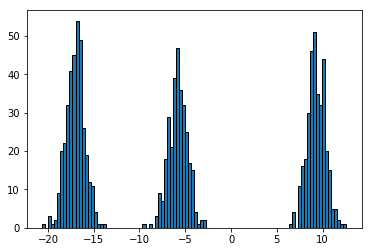

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(x, bins=100, ec='k');

We will find that it is convenient to write $z^{(i)}$ in vector form as a one-hot vector $\mathbf{z}^{(i)}$ where

 $$\mathbf{z}^{(i)}_k=\left\{
            \begin{array}{ll}
              1,z^{(i)} = k \\
              0,\text{  otherwise}\
            \end{array}
          \right. = \mathbb{1}_{z^{(i)} = k}$$.

The joint distribution over the data, latent variables and parameters can then be written as

$$p(\mathbf{x}, \mathbf{z}, \mathbf{\mu}) =   p(\mathbf{\mu})\prod_i p(x^{(i)}| \mathbf{z}^{(i)}, \mathbf{\mu}) 
\\= \prod_k p(\mu_k)\prod_i p(x^{(i)}| \mathbf{z}^{(i)}, \mathbf{\mu})
\\= \prod_k p(\mu_k)\prod_i \prod_k \left(p(x^{(i)}|\mu_k)p(\mathbf{z}^{(i)}_k = 1)\right)^{\mathbf{z}^{(i)}_k}$$

Writing $p(x^{(i)}| \mathbf{z}^{(i)})$ as a product over $k$ allows to explictly introduce the latent variables into the expression which will be convenient in the steps below. Note that if $\mathbf{z}^{(i)}_l = 1$, the product  $\prod_k \left(p(x^{(i)}|\mu_k)p(\mathbf{z}^{(i)}_k = 1)\right)^{\mathbf{z}^{(i)}_k}$ resolves to the factor corresponding to the value of the latent variable. So if $\mathbf{z}^{(i)}_l = 1$, then we get $p(x^{(i)}|\mu_l)\cdot\frac{1}{K}$ since the exponent $\mathbf{z}^{(i)}_k = 0$ for $k \neq l$ will make the remaining factors equal 1. 

Now we can write the joint log probability

$$p(\mathbf{x}, \mathbf{z}, \mathbf{\mu}) = \log\left(\prod_k p(\mu_k)\prod_i \prod_k \left(p(x^{(i)}|\mu_k)p(\mathbf{z}^{(i)}_k = 1)\right)^{\mathbf{z}^{(i)}_k}\right)\\
= \sum_k \log p(\mu_k) + \sum_i \sum_k \mathbf{z}^{(i)}_k\log\left(p(x^{(i)}|\mu_k)p(\mathbf{z}^{(i)}_k = 1)\right)
\\= \sum_k \log p(\mu_k) + \sum_i \sum_k \mathbf{z}^{(i)}_k\left(\log(p(x^{(i)}|\mu_k)  + \log p(\mathbf{z}^{(i)}_k = 1)\right)
\\= \sum_k\left(-\frac{1}{2}\log(2\pi\sigma^2) 
-\frac{1}{2}\frac{\mu_k^2}{\sigma^2} \right)
\\+ \sum_i \sum_k\mathbf{z}^{(i)}_k\left(-\frac{1}{2}\log(2\pi) 
-\frac{1}{2}{(x^{(i)} - \mu_k)^2}
- \log K\right)$$

The steps for variational inference as follows:

1. We specify the following categorical and normal distribtions for $z^{(i)}$ and $\mu_k$

$$q(z^{(i)}) = \text{Categorical}(w_{i1},\ldots ,w_{iK}) \implies q(z^{(i)} = k) = w_{ik}$$

$$q(\mu_k) = \mathcal{N}(\mu_k; m_k, s_k)$$
   
   
(Note that these are entirely different distributions from the prior distributions over $z^{(i)}$ and $\mu_k$.)


2. We first derive expressions for $q(\mu_k)$. Let us consider the distribution for $\mu_l$ and isolate the terms of the log probability that depend on it:

$$\log p(\mathbf{x}, \mathbf{z}, \mathbf{\mu}) 
= \text{const.} -\frac{1}{2}\left(\frac{\mu_l^2}{\sigma^2}
+ \sum_i \mathbf{z}^{(i)}_l{(x^{(i)} - \mu_l)^2}\right)
\\= \text{const.} -\frac{1}{2}\left( \mu_l^2\left(\frac{1}{\sigma^2} + \sum_i \mathbf{z}^{(i)}_l \right)
- 2\mu_l \sum_i \mathbf{z}^{(i)}_l x^{(i)}\right)
$$

Taking the expectation of this with respect to $q(\mathbf{\mu}_{-l})q(\mathbf{z})$:


$$E_{q(\mathbf{\mu}_{-l})q(\mathbf{z})}\left[\log p(\mathbf{x}, \mathbf{z}, \mathbf{\mu})\right] 
\\= \text{const.} -\frac{1}{2}\left( \mu_l^2\left(\frac{1}{\sigma^2} + \sum_i E_{q(\mathbf{z}^{(i)})}\left[\mathbf{z}^{(i)}_l\right] \right)
- 2\mu_l \sum_i E_{q(\mathbf{z}^{(i)})}\left[\mathbf{z}^{(i)}_l\right] x^{(i)}\right)
$$

Since $E_{q(\mathbf{z}^{(i)})}\left[\mathbf{z}^{(i)}_l\right] = 
p(\mathbf{z}^{(i)}_l = 1)\times1 + p(\mathbf{z}^{(i)}_l = 0)\times0 = p(\mathbf{z}^{(i)}_l = 1) = w_{il}$, we find that 

$$\log q(\mu_{l}) = \text{const.} -\frac{1}{2}\left( \mu_l^2\left(\frac{1}{\sigma^2} + \sum_i w_{il} \right)
- 2\mu_l \sum_i w_{il} x^{(i)}\right)
\\ \implies q(\mu_{l}) \propto \exp\left(-\frac{1}{2}\left( \mu_l^2\left(\frac{1}{\sigma^2} + \sum_i w_{il} \right)
- 2\mu_l \sum_i w_{il} x^{(i)}\right)\right)
$$

Completing the square for the expression inside the exponential, we can get $q(\mu_{l})$ into the form of a normal distribution:

$$q(\mu_{l}) \propto \exp\left(-\frac{1}{2}\left(\frac{1}{\sigma^2} + \sum_i w_{il} \right){\left(\mu_l
- \frac{\sum_i w_{il} x^{(i)}}{\frac{1}{\sigma^2} + \sum_i w_{il} }\right)^2}\right)$$

We can therefore identify the mean and the variance of $q(\mu_{l})$

$$s_l = \frac{1}{\frac{1}{\sigma^2} + \sum_i w_{il}}$$

$$m_l = \frac{\sum_i w_{il} x^{(i)}}{\frac{1}{\sigma^2} + \sum_i w_{il}}$$

Let us now define the update step for $s_l$ and $m_l$, given $w_{il}$

In [16]:
def update_params_mu(var_mu, mean_mu, prob_z, x, precision):
    var_mu = 1/(precision + np.sum(prob_z, axis=0))
    mean_mu = np.sum(prob_z*x[:, np.newaxis], axis=0)*var_mu
    
    return var_mu, mean_mu

Now let us consider the distribution for $\mathbf{z}^{(j)}$, $q\left(\mathbf{z}^{(j)}\right)$ and similarly isolate the terms corresponding to it

$$\log p(\mathbf{x}, \mathbf{z}, \mathbf{\mu}) 
= \text{const.} + \sum_k\mathbf{z}^{(j)}_k\left(-\frac{1}{2}\log(2\pi) 
-\frac{1}{2}{(x^{(j)} - \mu_k)^2}
- \log K\right)$$

Since $\sum_k\mathbf{z}^{(j)}_k = 1$, the terms in the sum above which don't depend on $k$ can be absorbed into the constant, leaving us with


$$\log p(\mathbf{x}, \mathbf{z}, \mathbf{\mu}) = \text{const.} -\frac{1}{2}\sum_k\mathbf{z}^{(j)}_k\left(\mu_k^2 - 2x^{(j)}\mu_k\right)$$

Taking the expectation with respect to $q(\mathbf{\mu})q\left(\mathbf{z}^{-(j)}\right)$

$$E_{q(\mathbf{\mu})q(\mathbf{z}_{-j})}\left[\log p(\mathbf{x}, \mathbf{z}, \mathbf{\mu})\right] 
= \text{const.} - \frac{1}{2}\sum_k\mathbf{z}^{(j)}_k\left(E_{q(\mu_l)}[\mu_k^2] - 2x^{(j)}E_{q(\mu_l)}[\mu_k]\right)
$$

Using the parameters of $q(\mu_k)$ and the fact that for any random variable $X$, $Var(X) = E[X^2] - E[X]^2 \implies E[X^2] = Var(X) + E[X]^2)$ we get


$$q\left(\mathbf{z}^{(j)}\right) \propto \exp\left(-\frac{1}{2}\sum_k\mathbf{z}^{(j)}_k\left(s_k + m_k^2 - 2x^{(j)}m_k\right)\right) $$




From this we can identify the probabilities for each element of $\mathbf{z}^{(j)}$, $\mathbf{z}^{(j)}_k$, $w_{jk}$ as

$$w_{jk} \propto \exp\left(-\frac{1}{2}\left(s_k + m_k^2 - 2x^{(j)}m_k\right)\right)$$

Equivalently we note that 

$$p(z^{(j)} = k) \propto \exp\left(-\frac{1}{2}\left(s_k + m_k^2 - 2x^{(j)}m_k\right)\right)$$

As above, we define an update step for $w_{jk}$ given $s_k$ and $m_k$

In [17]:
def update_params_z(prob_z, var_mu, mean_mu, x):
    prob_z = np.exp(-((var_mu + mean_mu**2)[np.newaxis] 
                            - 2*np.outer(x, mean_mu)))
    return prob_z/np.sum(prob_z, axis=-1, keepdims=True)

To run variational inference, we will alternately update the $s_k$  and $m_k$, and $w_{ik}$ until the maximum difference between consecutive estimates is below some threshold. Now let us assemble the update functions along with some others into a class to make it convenient to run the algorithm.

In [18]:
class MixtureOfGaussiansVI(object):
    
    def __init__(self, num_gaussians, sigma):
        self.num_gaussians = num_gaussians
        self.sigma = sigma
        self.precision = 1/self.sigma**2
    
    def update_params_z(self):
        exp_term = -((self.var_mu + self.mean_mu**2)[np.newaxis] 
                     - 2*np.outer(self.x, self.mean_mu))
        self.prob_z = np.exp(exp_term)
        self.prob_z/=np.sum(self.prob_z, axis=-1, keepdims=True)
        
    def update_params_mu(self):
        self.var_mu = 1/(self.precision + np.sum(self.prob_z, axis=0))
        self.mean_mu = np.sum(self.prob_z*x[:, np.newaxis], axis=0)*self.var_mu
    
    def _get_flattened_params(self):
        return np.concatenate([p.reshape(-1) for p in [self.prob_z, self.mean_mu, self.var_mu]])
    
    def update_step(self):
        params_prev = self._get_flattened_params()
        self.update_params_mu()
        self.update_params_z()
        self.errors.append(np.max(np.abs(self._get_flattened_params() - params_prev)))
        
    def run_vi(self, x, tol=1e-6, verbose=False):
        self.prob_z = (np.random.randint(0, self.num_gaussians, size=(len(x), 1)) 
                           == np.arange(self.num_gaussians)[np.newaxis]).astype('float')
    
        self.mean_mu = np.random.normal(loc=0, scale=self.sigma, size=self.num_gaussians)
        self.var_mu = np.abs(np.random.normal(loc=0, scale=self.sigma, size=self.num_gaussians))
        self.x = x
        
        self.errors = []
        
        while True:
            self.update_step()
            
            if verbose:
                sys.stdout.write('\rStep {:06d}, max error: {:.4f}'.format(
                    len(self.errors), self.errors[-1]))
            
            if self.errors[-1] < tol:
                break
    
    def get_params(self):
        #Sort the means as they are not likely to be in any particular order 
        #for ease of comparison with ground truth
        ag = np.argsort(self.mean_mu)
        return {param: getattr(self, param)[..., ag] 
                for param in ['mean_mu', 'var_mu', 'prob_z']}
    

In [19]:
num_samples = 1000
num_gaussians = 3
sigma = 4
MoGVI = MixtureOfGaussiansVI(num_gaussians, sigma)

In [20]:
# I wanted fairly well-separated Gaussians with a bit of overlap for
# demonstrating VI so I generated samples several until I got this and saved
# the state for reproducibility
if os.path.exists('mog_state.pkl'):
    with open('mog_state.pkl', 'rb') as f:
        state = pickle.load(f)
        np.random.set_state(state)
z, mu, x = sample_x(num_samples, MoGVI.num_gaussians, MoGVI.sigma)

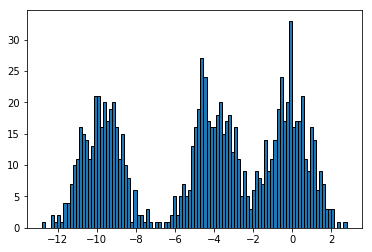

In [21]:
plt.hist(x, bins=100, ec='k');

In [22]:
MoGVI.run_vi(x, tol=1e-6, verbose=True)

Step 000014, max error: 0.0000

In [23]:
params = MoGVI.get_params()

In [24]:
mu, params

(array([-9.65247986, -4.11391039, -0.12146435]),
 {'mean_mu': array([-9.7747668 , -4.05027642, -0.07413286]),
  'var_mu': array([0.00309865, 0.00299589, 0.00290972]),
  'prob_z': array([[1.00000000e+00, 4.03665834e-13, 1.76254040e-38],
         [1.42201056e-46, 1.23911319e-09, 9.99999999e-01],
         [1.00000000e+00, 3.25659884e-13, 1.22491501e-38],
         ...,
         [3.59156997e-40, 5.21615482e-07, 9.99999478e-01],
         [7.73574510e-36, 3.11503735e-05, 9.99968850e-01],
         [1.00000000e+00, 5.99677468e-13, 3.44691815e-38]])})

Since the $s_k$, the variances for $\mu_k$, are quite small, let us use the estimates of the means $m_k$ and plot normal distributions $\mathcal{N}(m_k, 1)$ to compare with the distributions of the data $x$ belonging to each Gaussian. Taking the argmax of `prob_z` will gives us a prediction for each datapoint's mixture component and we will also plot the densities of the datapoints divided according to their predicted mixture component.  

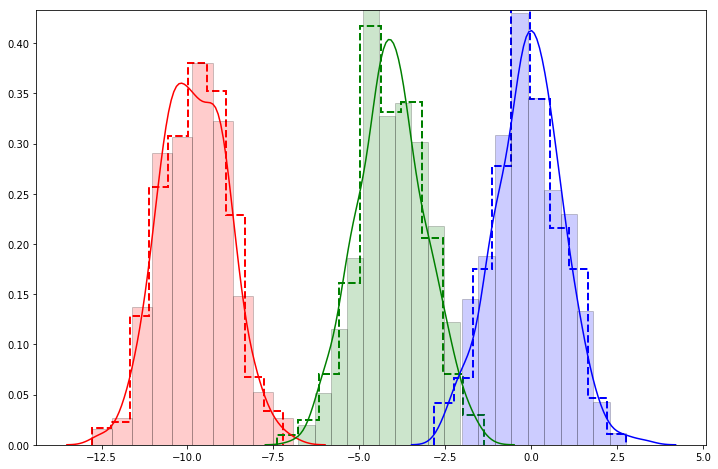

In [25]:
import seaborn as sns
c = ['red', 'green', 'blue']
plt.figure(figsize=(12,8))
for i in range(3):
    xi = x[z==i] #points actually in component i
    xi_ = x[params['prob_z'].argmax(axis=-1)==i] #points predicted to be in component i
    plt.hist(xi, histtype='step', color=c[i], density=True, lw=2, linestyle='--')
    plt.hist(xi_, ec='k', alpha=0.2, color=c[i], density=True)
    sns.kdeplot(np.random.normal(loc=params['mean_mu'][i], scale=1, size=xi_.shape), color=c[i])
    
    

Since we chose fairly well separated Gaussians, the results fit the data well with a few errors in the regions of overlap. This is also reflected in the confusion matrix between $z$ and the argmax of `prob_z`:

In [26]:
from sklearn.metrics import confusion_matrix
confusion_matrix(z, params['prob_z'].argmax(axis=-1))

array([[321,   0,   0],
       [  2, 322,   7],
       [  0,  10, 338]])